# 1. Thư viện

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import urllib.parse
import re
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import os
import time

# 2. Đọc và tiền xử lý dữ liệu

Do trong tập dữ liệu có những đường link được update liên tục theo thời gian thực, có một số công việc có thể đã được nhận và không còn hiện JD, có một số trường hợp không thể tải được trang (linkedin.com).

Vì vậy, việc xử lý dữ liệu ở bước này chỉ là tạm thời, trong quá trình cào JD sẽ còn phải xử lý thêm nếu phát hiện những link có vấn đề.

In [23]:
df = pd.read_csv('./data.csv')
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )
0,3165,Undisclosed,"Leader, Data Engineer","Senior, Lead",NaN,HN,NaN,Tới khi đóng link,Fulltime,Hà Nội tuyển dụng tech leader Data Engineer Go...,https://www.facebook.com/groups/datanalyticsvn...,NaN
1,3164,Abbott,Market Analyses And Business Intelligence Manager,Manager,8.0,HCM,4,Tới khi đóng link,Fulltime,Minimum 8 years; Proven experience in business...,https://abbott.wd5.myworkdayjobs.com/en-US/abb...,NaN
2,2839,TEAM DATAJOBS,Data & Domain Mentor,"Junior, Senior, Manager, Senior Manager+++",1.0,Remote,NaN,Tới khi đóng link,"Part-time, Freelance","- Giờ giấc linh hoạt, tự đề xuất mức phí, 100%...",https://docs.google.com/spreadsheets/d/1kCr2Pn...,NaN
3,3163,Undisclosed,Business Intelligence Analyst,Senior,3.0,HCM,"2,2",Tới khi đóng link,Fulltime,At least 3 years of experience as BI Analyst,https://www.linkedin.com/jobs/view/business-in...,NaN
4,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1591,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...,NaN
1592,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...,NaN
1593,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...,Chuyên viên Tư vấn Giải pháp Dữ liệu
1594,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...,NaN


In [3]:
df.columns

Index(['Job ID', 'JD Company', 'JD Title ( Eng )', 'JD Level', 'JD YOE Min',
       'JD Location', 'JD Gross Salary Max*', 'JD Due Date', 'JD Working Hour',
       'JD Note', 'JD Details', 'JD Title ( Vie )'],
      dtype='object')

Ý nghĩa tên các cột:
- Job ID: Mã công việc
- JD Company: Công ty tuyển việc
- JD Title (Eng): Tên công việc bằng tiếng Anh
- JD Level: Bằng cấp yêu cầu
- JD YOE Min: Sô năm kinh nghiệm tối thiểu
- JD Location: Nơi tuyển công việc
- JD Gross Salary Max*: Tổng thu nhập cao nhất của công việc
- JD Due Date: Ngày hết hạn tuyển
- JD Working Hour: Giờ làm việc của công việc
- JD Note: Chú thích công việc
- JD Details: Đường link chứa thông tin công việc
- JD Title (Vie): Tên công việc bằng tiếng Việt

In [4]:
df[df['Job ID'].duplicated(keep=False)]

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )


Không có Job nào bị trùng ID

In [5]:
df[df['JD Company'].isnull()]

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )


Không có dữ liệu thiếu tên công ty

In [6]:
df['JD Company'].unique()

array(['Undisclosed', 'Abbott', 'TEAM DATAJOBS', 'Shinhan Bank Vietnam',
       'ASIM Telecom ( ASIM GROUP )', 'GHN', 'PREP', 'HBLAB', 'Neos',
       'Cartrack', 'Savills', 'Menard', 'CoderPush', 'VNG Corporation',
       'Yes4All', 'FPT', 'Central Retail', 'New Ocean IS',
       'NielsenIQ ( NIQ )', "Adecco's Client", 'CJ Foods', 'HSBC',
       'B.Braun Vietnam', 'GBG Group Services', 'Sika', 'Noventiq',
       "RGF's Client", 'Finhay', 'Unravel Carbon', 'AB InBev', 'Shopee',
       'New Viet Dairy', 'HCLTech Vietnam', 'Lazada', 'TV TPI', 'OCB',
       'Sacombank', 'U&I Logistics', 'Barsan Global Logistics',
       'GSoft ( Phan mem Hoan Cau )', "Robert Walters's Client",
       'Watsons', 'PNJ', 'SharkNinja', 'Simpson Strong-Tie', 'SnapTec',
       'Pi Associates', "Manpower's Client", 'Suntory PesiCo', 'Savvycom',
       'Tekcom', 'HD Saison', 'Ministop', 'NMS', 'Asilla',
       'Amaris Consulting', 'Ahamove', 'VPBank', 'Phong Vu',
       'INNOVATURE BPO', 'BAEMIN Vietnam ( Woowa Br

In [7]:
len(df['JD Company'].unique())

639

Có tổng cộng 639 công ty khác nhau trong tập dữ liệu này

In [24]:
for i in range(len(df)):
    url = df.loc[i, 'JD Details']
    
    try:
        response = requests.get(url, timeout=10)
        print(i)
        if response.status_code != 200:
            df.drop(i, inplace=True)
    except requests.exceptions.RequestException as e:
#         print(f"Error accessing URL: {url}")
#         print(f"Error details: {e}")
        df.drop(i, inplace=True)

0
1
2
4
5
7
8
9
11
12
13
14
15
16
17
18
22
23
24
25
26
27
28
29
30
31
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
53
54
55
57
58
59
60
61
62
63
64
65
66
67
68
69
71
72
73
74
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
95
96
97
98
99
100
102
103
104
105
107
108
109
110
111
112
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
135
136
137
138
139
140
141
142
143
144
145
146
148
149
150
152
153
154
155
158
159
161
162
163
164
165
166
167
168
170
171
172
173
174
175
176
177
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
213
214
215
217
218
219
220
221
222
225
226
227
229
230
231
232
233
234
236
237
238
239
240
241
242
243
244
248
249
252
253
255
256
257
261
262
263
265
266
267
268
271
272
274
275
276
277
280
283
284
285
286
287
288
289
291
292
293
296
297
299
300
301
302
303
304
306
310
311
313
314
315
316
318
320
321
322
324
325
326
329
330
331
332
333
334
335
336
337
33

Cần phải tìm ra các bản ghi có đường link báo lỗi (là các đường link có status code khác 200)

Sau khi tìm được ta cần phải loại bỏ chúng để thuận lợi làm các bước tiếp theo.

In [25]:
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )
0,3165,Undisclosed,"Leader, Data Engineer","Senior, Lead",NaN,HN,NaN,Tới khi đóng link,Fulltime,Hà Nội tuyển dụng tech leader Data Engineer Go...,https://www.facebook.com/groups/datanalyticsvn...,NaN
1,3164,Abbott,Market Analyses And Business Intelligence Manager,Manager,8.0,HCM,4,Tới khi đóng link,Fulltime,Minimum 8 years; Proven experience in business...,https://abbott.wd5.myworkdayjobs.com/en-US/abb...,NaN
2,2839,TEAM DATAJOBS,Data & Domain Mentor,"Junior, Senior, Manager, Senior Manager+++",1.0,Remote,NaN,Tới khi đóng link,"Part-time, Freelance","- Giờ giấc linh hoạt, tự đề xuất mức phí, 100%...",https://docs.google.com/spreadsheets/d/1kCr2Pn...,NaN
4,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...,NaN
5,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1591,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...,NaN
1592,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...,NaN
1593,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...,Chuyên viên Tư vấn Giải pháp Dữ liệu
1594,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...,NaN


Sau khi xóa các bản ghi có link lỗi, ta còn 994 bản ghi (1596 -> 994)

In [26]:
df.to_csv('data2.csv')

Ta cần lưu lại DataFrame sau khi đã xử lý

In [2]:
df = pd.read_csv('./data2.csv',index_col=0)
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )
0,3165,Undisclosed,"Leader, Data Engineer","Senior, Lead",NaN,HN,NaN,Tới khi đóng link,Fulltime,Hà Nội tuyển dụng tech leader Data Engineer Go...,https://www.facebook.com/groups/datanalyticsvn...,NaN
1,3164,Abbott,Market Analyses And Business Intelligence Manager,Manager,8.0,HCM,4,Tới khi đóng link,Fulltime,Minimum 8 years; Proven experience in business...,https://abbott.wd5.myworkdayjobs.com/en-US/abb...,NaN
2,2839,TEAM DATAJOBS,Data & Domain Mentor,"Junior, Senior, Manager, Senior Manager+++",1.0,Remote,NaN,Tới khi đóng link,"Part-time, Freelance","- Giờ giấc linh hoạt, tự đề xuất mức phí, 100%...",https://docs.google.com/spreadsheets/d/1kCr2Pn...,NaN
3,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...,NaN
4,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
989,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...,NaN
990,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...,NaN
991,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...,Chuyên viên Tư vấn Giải pháp Dữ liệu
992,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...,NaN


# 3. Cào dữ liệu

## Loại bỏ các link không  thể cào và tạo 1 DataFrame chứa các class để cào

In [3]:
domain_list = list()
for i in range(len(df)):
    url = df.loc[i, 'JD Details']
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc
    if domain not in domain_list:
        domain_list.append(domain)

In [4]:
domain_list

['www.facebook.com',
 'abbott.wd5.myworkdayjobs.com',
 'docs.google.com',
 'www.topcv.vn',
 'www.linkedin.com',
 'careers.prep.vn',
 'hblab.vn',
 'jobsgo.vn',
 'www.savills.com.vn',
 'itviec.com',
 'mycareer.hsbc.com',
 'glints.com',
 'jobs.jobvite.com',
 'www.rgf-hragent.asia',
 'www.finhay.com.vn',
 'careers.shopee.sg',
 'lazada.com',
 'vieclamtphcm.vn',
 'sacombankcareer.com',
 'www.vietnamworks.com',
 'careers.savvycom.vn',
 'manpower.com.vn',
 'tuyendung.vpbank.com.vn',
 'careersatagoda.com',
 'jobs.smartrecruiters.com',
 'careers.tiktok.com',
 'www.ogilvy.com',
 'careerstart.vn',
 'axpara.com',
 'www.deltacognition.com',
 'prudential.wd3.myworkdayjobs.com',
 'elfie.freshteam.com',
 'jobs.hrs.com',
 'www.pti.com.vn',
 'careers.tapestry.com',
 'careers.uobgroup.com',
 'jobs.gecareers.com',
 'amperecomputing.com',
 'topdev.vn',
 'adecco.com.vn',
 'www.careerlink.vn',
 'freec.asia',
 'sealcommerce.asia',
 'careers.frieslandcampina.com',
 'manulife.wd3.myworkdayjobs.com',
 'www.techco

Ta cần tạo ra một DataFrame mới có chứa các đường link gốc và html class để có thể cào dữ liệu từ các trang đó. Ví dụ:
- www.topcv.vn là 1 đường link gốc, vì trong tập dữ liệu nó có các đường link con từ nó như:    
    + https://www.topcv.vn/viec-lam/ai-quantitative-researcher/782374.html       
    + https://www.topcv.vn/viec-lam/data-analytics-supervisor-hcm/1033042.html
- Để có thể cào dữ liệu từ các đường link con của www.topcv.vn, ta cần dùng class là "job-data", ta có thể tìm thông qua thẻ div class="Name" ở HTML của các link con bất kỳ
- Cần làm tương tự với các đường link gốc trên
- Trong quá trình tìm kiếm, có một số ít đường link khó để cào được JD bằng cách trên nên sẽ bỏ qua (các đường link có chứa "wd3", "wd5",...)
- Ta sẽ loại bỏ một số đường link bắt phải đăng nhập hoặc không thể xem được HTML như facebook và các dịch vụ của google (docs, drive)

In [19]:
class_df[class_df['Links'] == 'drive.google.com']

,Links,Class
113,drive.google.com,NaN


In [70]:
class_df = pd.DataFrame({"Links": domain_list, "Class": [float('nan')] * len(domain_list)})
class_df.drop([0,1,2,113],inplace=True)
class_df
# Bỏ facebook vì cần phải đăng nhập và tham gia nhóm mới có thể hiện nội dung bài viết
# Bỏ docs và drive, abbott vì ko cào được


,Links,Class
3,www.topcv.vn,NaN
4,www.linkedin.com,NaN
5,careers.prep.vn,NaN
6,hblab.vn,NaN
7,jobsgo.vn,NaN
...,...,...
207,www.aitomatic.com,NaN
208,supercell.com,NaN
209,waverleysoftware.com,NaN
210,www.supercoder.co,NaN


In [65]:
unwanted = ['www.facebook.com','docs.google.com','drive.google.com','abbott.wd5.myworkdayjobs.com']
for i in range(len(df)):
    url = df.loc[i, 'JD Details']
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc
    if domain in unwanted:
        df.drop(i,inplace=True)
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )
1,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...,NaN
2,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146,NaN
3,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/,NaN
4,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/,NaN
5,3157,Neos,AI Engineer,"Junior, Senior",NaN,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
775,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...,NaN
776,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...,NaN
777,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...,Chuyên viên Tư vấn Giải pháp Dữ liệu
778,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...,NaN


Ta cần loại bỏ các đường link khó để cào được ra khỏi DataFrame vào lưu trữ lại

In [66]:
df.to_csv('data3.csv')

## Một số ví dụ cào dữ liệu ở các link

Để có thể cào được các JD từ các trang web khác nhau, ta sẽ sử dụng thư viện:
- requests: để tìm được status code của đường link hiện tại
- selenium: để có thể lấy được page source của link
- BeautifulSoup: để có thể tìm được JD thông qua các thẻ HTML
- urllib: để tìm được link gốc trong các link con
- re (regex): có một số ít đường link có JD được chia làm nhiều phần, mỗi phần ở một thẻ class khác nhau, nhưng các thẻ class chỉ khác nhau ở một số ký tự, nên ta cần dùng regex để có thể tìm được các thẻ class như vậy (Sau khi chạy xong hết chương trình thì ta sẽ thấy rằng khi lưu trữ ở trong dataframe, regex sẽ biến thành string, cho nên cách dùng regex này không áp dụng được)

In [67]:
response = requests.get('https://www.finhay.com.vn/tuyen-dung/data-scientist')
html_content = response.content
soup = BeautifulSoup(html_content, "html.parser")
job_description_elem = soup.find("div", {"class": "box_content"})
if job_description_elem:
    job_description = job_description_elem.get_text()
    print(job_description)
else:
    print("No job description found")


Finhay – a fintech company, which provides small and medium investors with technology solutions and smart applications that are applicable to savings and investments in VietNam. Finhay’s financial products are based on the digital platform to enhance its users’ diversified and ultimate personal portfolios. At the same time, Finhay prioritizes financial integrity and users’ benefits, allowing them to save, or invest their limited capital flexibly, and build their desired assets, hedging their future. Finhay was certified as an “Enterprise of Science and Technology” by HaNoi Department of Science and Technology, Finhay was also one of the two fintech companies in VietNam, which were listed in “2019 World Top 100 Fintech” – assessed by KPMG.
 
If you are an experienced Data Scientist who is driven to deliver business value, passionate about extracting insights and patterns from data, and enjoys tackling challenging problems, this exciting position is for you.
 As a Data Scientist, your p

In [17]:
response = requests.get('https://docs.google.com/spreadsheets/d/1kCr2PnpUl5ZBPtULtY3TPu8JYFFm3xcebHedKvyJpdk/edit')
html_content = response.content
soup = BeautifulSoup(html_content, "html.parser")
job_description_elem = soup.find_all("div", {"class": "docs-editor-container"})
for jd in job_description_elem:
    job_description = jd.get_text()
    print(job_description)

In [53]:
response = requests.get('https://glints.com/vn/opportunities/jobs/demand-planning-specialist/0b152654-7533-40e8-bf57-bc1d8921eb84')
html_content = response.content
soup = BeautifulSoup(html_content, "html.parser")
job_description_elem = soup.find("div", {"class": re.compile("Opportunitysc")})
for jd in job_description_elem:
    job_description = jd.get_text()
    print(job_description)

Phúc lợi công việc Hoạt động team-buildingOur company simply cannot function well without teams of people working together. That said, we provide numerous team-building activities and events for you and your team to nurture meaningful relationships between every individual. Cơ hội phát triển nghề nghiệpEver feel stuck with your career? We don't hire you simply because we needed to fill an empty slot. Together, we will help you shape and grow your career so you can progress further and rediscover your true sense of purpose at work. Bảo hiểmUnexpected things may happen at unexpected times. We cover basic insurance costs for you and your loved ones in case of emergencies or unfortunate events. You can also upgrade your plan any time you want. Nghỉ phépFeel a need for a short break from work? our company is quite flexible when it comes to leaves; be it for vacation, sick, personal, or mental health days. Simply discuss what you need and we will try to cater to those.XEM THÊM 2 PHÚC LỢI Ski

In [72]:
url = ['https://www.finhay.com.vn/tuyen-dung/data-scientist',
      'https://glints.com/vn/opportunities/jobs/demand-planning-specialist/0b152654-7533-40e8-bf57-bc1d8921eb84',
      'https://jobsgo.vn/viec-lam/bi-developer-15302799734.html',
      ]

regex = "Opportunitysc|content-group|box_content"
pattern = re.compile(regex)

In [77]:
for link in url:
    response = requests.get(link)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")
    job_description_elem = soup.find_all("div", {"class": pattern})
    for jd in job_description_elem:
        job_description = jd.get_text()
        print(job_description)
    print('-----------------------------------------------------------------------------')


Finhay – a fintech company, which provides small and medium investors with technology solutions and smart applications that are applicable to savings and investments in VietNam. Finhay’s financial products are based on the digital platform to enhance its users’ diversified and ultimate personal portfolios. At the same time, Finhay prioritizes financial integrity and users’ benefits, allowing them to save, or invest their limited capital flexibly, and build their desired assets, hedging their future. Finhay was certified as an “Enterprise of Science and Technology” by HaNoi Department of Science and Technology, Finhay was also one of the two fintech companies in VietNam, which were listed in “2019 World Top 100 Fintech” – assessed by KPMG.
 
If you are an experienced Data Scientist who is driven to deliver business value, passionate about extracting insights and patterns from data, and enjoys tackling challenging problems, this exciting position is for you.
 As a Data Scientist, your p


Bi Developer

 Hết hạn trong  13  ngày nữa 
 Mức lương Thỏa thuận




 Ứng tuyển ngay
  Lưu lại    Chia sẻ 




Địa điểm làm việc

  Hồ Chí Minh -   Việc làm tại Hồ Chí Minh
 



Ngành nghề
 SQL ,  Data Analytics ,  CNTT - Phần Mềm 

Mô tả công việc
 Analyzing and designing Information systems:
- Analyze business processing or Business needs and system design, using techniques such as, pattern design, data modeling and requirement analysis.
- Utilize the information system in the process analysis and solution of business problems such as development of integrated production and inventory control and cost analysis systems.
- Define the business goals and devise business flow diagrams describing logical operational steps of programs.
- Assess the usefulness of pre-developed application packages and adapt them to a user environment.
Implementing and developing the Information systems:
- Use object-oriented programming languages, as well as client and server applications development proce

In [ ]:
for for i in range(len(df)+1):
    url = df.loc[i,'JD Details']
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc
    if domain == 'facebook.com':
        df.drop(i,inplace=True)

In [96]:
regex = "(job.*)|(.*content)|(.*description)|(.*data)"
pattern = re.compile(regex)

In [97]:
for i in range(len(df)+1):
    url = df.loc[i,'JD Details']
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")
    job_description_elem = soup.find_all("div", {"class": pattern})
    for jd in job_description_elem:
        job_description = jd.get_text()
        print(job_description)
    print('-----------------------------------------------------------------------------')

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------



TopCV - Tiếp lợi thế, nối thành công

















Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp






Không hiển thị lại





Tìm hiểu thêm






Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp




Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản




Senior Data Engineer

Công ty Cổ phần ASIM Group
Vietnam












Direct message the job poster from Công ty Cổ phần ASIM Group





            
        Hồ Linh




              
        A senior PEOPLE-ORIENTED HR seeking for Employee Empowering ways via better employee engagement and enablement
      
            

 










Senior Data Engineer là người góp phần cùng ASG mang lại những sản phẩm công nghệ có sức ảnh hưởng tới cuộc sống của người Việt, bạn sẽ cùng team Data thuộc Khối Công nghệ của ASG thực hiện những việc sau:Xây dựng database khách hàng, quản lý chất lượngThiết kế, xây dựng và khởi chạy các quy trình xuất, chuyển đổi và tải dữ liệu mớiPhụ trách nghiên cứu các công cụ để phát triển tính năng cho phần mềm dữ liệu hỗ trợ công việc/ kỹ năng kiến thức về phân tíchPhối hợp với đội CNTT nội bộ để làm rõ các yêu cầu về kiến trúc tích hợp dữ liệuKhai thác, phân tích và xử lý từ dữ liệu nguồn để tổng hợp về kho dữ liệuTriển khai và quản lý công việc, chi phí theo kế








Giới thiệu chung
HBLAB với thế mạnh về Web & App, AI, chúng tôi đã và đang liên tục nghiên cứu, phát triển, tạo ra những giá trị tích cực cho xã hội. Trên hành trình nâng tầm chất lượng Việt Nam, HBLAB luôn kiếm tìm những con người nhiệt huyết tham gia vào đội ngũ nhân sự tài năng, hoài bão để cùng nhau học hỏi, phát triển và thành công.







Mô tả công việc
– Nghiên cứu đề xuất các giải pháp về AI (Computer Vision) 
– Triển khai giải pháp trên Cloud & edge device (jetson nano, Pi3…)







Yêu cầu công việc
– Tối thiểu 2 năm kinh nghiệm thực tế trong các dự án lĩnh vực Computer Vision (Object Detection, Segmentation, GAN, OCR …) 
– Thành thạo các AI Engine phổ biến: Tensorflow, Pytorch… 
– Am hiểu về Image Processing, Machine Learning và Deep Learning 
– Có khả năng đề xuất giải pháp các bài toán về Computer Vision đa dạng 
– Có kinh nghiệm làm việc trên AWS/ GLC/ Azure (Deploy các sản phẩm AI trên 1 trong các nền tảng trên) 
– Đã deploy các sản phẩm AI trên edge device 
– Có



     Savills uses necessary cookies to operate our website. We will also use cookies to enhance your experience with Savills, including to show you more personalised content and tailored advertisements, if you select “Allow all cookies”.
      More info.


      Allow all cookies
    






Vietnam


Location




Abu Dhabi
Antigua
Australia
Austria
The Bahamas
Bahrain
Barbados
Belgium
Botswana
Canada
Cayman Islands
China
Croatia
Czech Republic
Cyprus
Denmark
Dubai
Egypt
Estonia
Finland
France
Germany
Gibraltar
Greece
Guernsey
Hong Kong SAR
Hungary
India
Indonesia
Ireland
Israel
Italy
Japan
Jersey
Kenya
Korea
Latvia
Lithuania
Luxembourg
Macao SAR
Malaysia
Mauritius
Mexico
Monaco
Montenegro
Mozambique
Namibia
The Netherlands
New Zealand
Norway
Oman
Pakistan
The Philippines
Poland
Portugal
Qatar
Romania
Saudi Arabia
Serbia
The Seychelles
Sharjah
Singapore
South Africa
Spain
St Kitts & Nevis
Sweden
Switzerland
Taiwan, China
Thailand
Turks & Caicos
UAE
United Kingdom
United States
Vietnam

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

Jobs by Skill







Java
PHP
JavaScript
HTML5
Manager
SQL
Android
iOS


MySQL
Tester
English
Ruby
Python
Mobile Apps
Ruby on Rails
QA QC


Database
.NET
Business Analyst
Linux
Team Leader
NodeJS
System Engineer
Designer


UI-UX
Project Manager
OOP
Oracle
MVC
ReactJS
Embedded
J2EE



View all Jobs by skill






Jobs by Title







Java Developer
PHP Developer
Javascript Developer
HTML5 Developer
SQL Developer
Android Developer
iOS Developer
Tester


Ruby Developer
Python Developer
Ruby On Rails Developer
.NET Developer
NodeJS Developer
Linux Developer
OOP Developer
Oracle Developer


C++ Developer
Wordpress Developer
Designer
Database Administrator
Mobile Apps Developer
Project Manager
Product Owner
Bridge Engineer



View all Jobs by title






Jobs b

Login

You’re an important part of our future. Hopefully, we're also a part of yours! At B. Braun, we protect and improve the health of people worldwide. This is also our vision for research and development. You see complexity as an opportunity – and quality and sustainability are important criteria for your work. We would like to work with you on tomorrow’s solutions. That’s how we work to create sustainable healthcare – locally, in regions, countries and worldwide. Together. That's Sharing Expertise.“It’s for whom sufficiently Self-motivated, Proactive and Determined candidates to start by own direction on career to pursue further learning and challenges in order to Be Greater at B. Braun Vietnam”B. Braun Vietnam (BBVN) Fresh Speed Up is a professional training and on-the-job development program for final year student or fresh graduates with less than 1 year of working experience. This program develops young and willing-to-learn talents into the next generation of BBVN employees.This




TopCV - Tiếp lợi thế, nối thành công

















Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp






Không hiển thị lại





Tìm hiểu thêm






Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp




Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!















Tất cả tỉnh/thành phố
Hà Nội
Hồ Chí Minh
Bình Dương
Bắc Ninh
Đồng Nai
Hưng Yên
Hải Dương

-----------------------------------------------------------------------------




















Careers
Culture
Meet Our Team
Noventiq.com













Careers
Culture
Meet Our Team
Noventiq.com








            The job listing no longer exists.
        










Trust us your career and we'll change your future!
We are a global team of high professionals who are interested in new technologies, opened to new experiences and eager to drive digital transformation.
Join Noventiq Team!


Department:



Select a Department
{{ item.name }}




Location:



Select a Location
{{ item.name }}




Keyword:






Created Date:







Reset
Search







We have rebranded!




30 years ago we started as a local software reseller with the team of 10 employees, dreaming of $1-2 million in turnover and we have grown into Global Digital Transformation & Cybersecurity Leader with a strong world-class team of 3900 employees working in 50+ countries.
Today we are now a publicly listed company at th




















Tích lũy
Đầu tư
Bảo vệ
Hoàn tiền
Hỗ trợ
Kiến thức



Đăng Nhập











Cơ hội nghề nghiệpcùng Finhay












Data Scientist

 
                Địa điểm: 
                


    Hà Nội 


 Ngày đăng: 28/05/2023            





Finhay – a fintech company, which provides small and medium investors with technology solutions and smart applications that are applicable to savings and investments in VietNam. Finhay’s financial products are based on the digital platform to enhance its users’ diversified and ultimate personal portfolios. At the same time, Finhay prioritizes financial integrity and users’ benefits, allowing them to save, or invest their limited capital flexibly, and build their desired assets, hedging their future. Finhay was certified as an “Enterprise of Science and Technology” by HaNoi Department of Science and Technology, Finhay was also one of the two fintech companies in VietNam, which were listed in “2019 World Top 100 Fintech” – assessed by KPMG




Data Engineer (Ho Chi Minh)

Unravel Carbon (YC W22)
Ho Chi Minh City, Vietnam



        Apply
      


 


Save job



 














        Save this job with your existing LinkedIn profile, or create a new one.
      
          

            
        Your job seeking activity is only visible to you.
      
          



          Email
        










            Continue
          




        Welcome back
      

          
          
        Sign in to save Data Engineer (Ho Chi Minh) at Unravel Carbon (YC W22).
      
        
        
















          Email or phone
        









          Password
        


Show





 

Forgot password?



          Sign in
        

 




 









        Save this job with your existing LinkedIn profile, or create a new one.
      
          

            
        Your job seeking activity is only visible to you.
      
          



          Email
        










            Continue
          




        Welco




 Reporting & Performance Manager

AB InBev Southeast Asia
Ho Chi Minh City, Vietnam



        Apply
      


 


Save job



 














        Save this job with your existing LinkedIn profile, or create a new one.
      
          

            
        Your job seeking activity is only visible to you.
      
          



          Email
        










            Continue
          




        Welcome back
      

          
          
        Sign in to save  Reporting & Performance Manager at AB InBev Southeast Asia.
      
        
        
















          Email or phone
        









          Password
        


Show





 

Forgot password?



          Sign in
        

 




 









        Save this job with your existing LinkedIn profile, or create a new one.
      
          

            
        Your job seeking activity is only visible to you.
      
          



          Email
        










            Continue
          




   

-----------------------------------------------------------------------------



Finance Analyst Supervisor


Ho Chi Minh City, Vietnam












Direct message the job poster from 145 Ton That Dam





            
        Anh Tú (Too)




              
        Hiring: Finance Analyst Supervisor, Senior Marcom Executive
      
            

 










Finance Business Partner for Sales and MarketingControl cost and improve the efficiency of a marketing program, trade promotion program Assist to developed and evaluating financial, sales, and pricing modelsMaking tariffs for new products efforts through in-depth financial analysis and modeling for new products / new customersAnalyze sales performances to make forecast sales trends with respect to performance vs the Prior Year, Forecast and Plan, and work with FP&A and the Commercial team to reflect those trends into the Budget/ForecastAssist to develop a financial analysis that challenges & evaluates all marketing investment decisio




(HCMC) GCP Cloud Data Engineer – Upto 1 Billion/Year

HCLTech Vietnam 
Ho Chi Minh City, Vietnam












Direct message the job poster from HCLTech Vietnam 





            
        Thúy Huyền (Smith)




              
        Senior Talent Acquisition Executive at HCLTech Vietnam
      
            

 










***Note: We highly appreciate your interest in this position of HCL Vietnam. After reviewing all applications, only qualified candidates will be contacted for the next steps within 15 days from date of submissionABOUT HCL VIETNAM COMPANY LIMITEDHCL Vietnam Company Limited belongs to HCLTech which is a global technology company, home to 222,270+ people across 60 countries, delivering industry-leading capabilities centered around digital, engineering and cloud, powered by a broad portfolio of technology services and products. We work with clients across all major verticals, providing industry solutions for Financial Services, Manufacturing, Life Sciences and Healthcare,





GO BACK











Department:
Commercial




Location:
Vietnam








Department:
Commercial






Location:
Vietnam








Job Description


Team and Role Introduction: Strategic and Planning (SnP) is one of the key drivers to the success of Category execution, campaigns, traffic mechanics, and thereby business target. The role will provide standardized methodology, data reports and insights to Commercial Teams to realize growth opportunities, address potential setbacks while fostering effective daily operations. Responsibilities: • Working closely with SnP lead to review commercial performances, analyze key impacting factors & deep dive potential areas for growth. • Building and maintaining automated dashboards for performance tracking & analysis serving categories’ demand. • Owning & managing performances of selected products/ functional areas. This may include but not limited to: Deal hunting, Assortment building, Pricing strategy, Tools adoption & investments. • Coordinatin











VIP






                                    Chuyên Viên Phân Tích Dữ Liệu Kinh Doanh Dược Phẩm
                                    
                                        TV TPI CO., LTD
                                    






Chia sẻ công việc



 



Lưu công việc




 


Ứng tuyển ngay









Mức lương

Thương lượng




Ngành nghề


                                        Bán hàng / Kinh doanh
                                    

                                        Công nghệ thực phẩm / Dinh dưỡng
                                    

                                        Kế toán / Kiểm toán
                                    




Hạn nộp hồ sơ


                                        30/06/2023
                                    




Địa điểm


                                        Quận Bình Thạnh
                                    

                                        Quận Phú Nhuận
                                    

                          




Finance Analyst Specialist

GiaoHangNhanh (GHN)
Ho Chi Minh City, Vietnam












Direct message the job poster from GiaoHangNhanh (GHN)





            
        Kiều Nguyễn




              
        Looking for Business Development Executive/Specialist, B2B Business Development Executive/Specialist
      
            

 










MÔ TẢ CÔNG VIỆC:Phối hợp và chuẩn bị ngân sách, dự báo tài chính/dòng tiền cho các dự án của GHN Cập nhật, kiểm soát ngân sách hàng tháng.Lập và công bố báo cáo tài chính theo định kỳQuản lý các giao dịch tài chính của các dự ánYÊU CẦU:Tối thiểu 5 năm kinh nghiệm ở vị trí tương đương (Corporate Finance)Có kiến thức về các nguyên tắc, quy trình, thủ tục kế toán.Có kinh nghiệm lập báo cáo tài chính.Tư duy logic, tổng hợp và phân tích số liệu tốt.Giải quyết vấn đề tốt.Có kỹ năng giao tiếp tốt.Trung thực, cẩn thận, chú ý chi tiết.Thành thạo Tiếng Anh, tin học văn phòng, đặc biệt là Excel.THỜI GIAN LÀM VIỆC: Từ Thứ 2 - Thứ 6 (8h30 - 18h00).ĐỊA CHỈ LÀM VI

Việc LàmViệc Làm Quản LýCâu Hỏi Phỏng VấnMức LươngWater EngineerWha Việt NamHà Nội, Nghệ AnThương lượngHết hạn trong 20 ngàyData Partner – Chuyên Gia Đối Tác Dữ Liệu – Hà NộiVPBank - Https://tuyendung.vpbank.com.vn/Hà NộiThương lượngHết hạn trong 28 ngàyChuyên Viên Phân Tích Nghiệp Vụ (Business Analyst)Công Ty TNHH Jungdo UitHà NộiThương lượngHết hạn trong 9 ngàyOversea Sales StaffToshiba Transmission & Distribution Systems (Vietnam)Hà NộiThương lượngHết hạn trong 30 ngàyIT Data Analytics SpecialistNestlé Vietnam Ltd.,Hồ Chí MinhThương lượngHết hạn trong 6 ngàyTrang chủViệc làmViệc làm data analystGửi tôi việc tương tựNhận thông báo Từ khóa liên quanicons/icon-forms/icon-arrow-down@1xKinh DoanhTiếng AnhBán HàngChăm Sóc Khách HàngTìm Kiếm Khách HàngAutoCADBusiness DevelopmentKế ToánTài ChínhDigital MarketingAccountingCommunicationCustomer ServiceProject ManagementLogisticsSắp xếp theoMặc địnhLiên quanLương (cao - thấp)Ngày đăng (mới nhất)Ngày đăng (cũ nhất)Loading interface...Loading in




TopCV - Tiếp lợi thế, nối thành công

















Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp






Không hiển thị lại





Tìm hiểu thêm






Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp




Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!















Tất cả tỉnh/thành phố
Hà Nội
Hồ Chí Minh
Bình Dương
Bắc Ninh
Đồng Nai
Hưng Yên
Hải Dương


Jobs by Skill







Java
PHP
JavaScript
HTML5
Manager
SQL
Android
iOS


MySQL
Tester
English
Ruby
Python
Mobile Apps
Ruby on Rails
QA QC


Database
.NET
Business Analyst
Linux
Team Leader
NodeJS
System Engineer
Designer


UI-UX
Project Manager
OOP
Oracle
MVC
ReactJS
Embedded
J2EE



View all Jobs by skill






Jobs by Title







Java Developer
PHP Developer
Javascript Developer
HTML5 Developer
SQL Developer
Android Developer
iOS Developer
Tester


Ruby Developer
Python Developer
Ruby On Rails Developer
.NET Developer
NodeJS Developer
Linux Developer
OOP Developer
Oracle Developer


C++ Developer
Wordpress Developer
Designer
Database Administrator
Mobile Apps Developer
Project Manager
Product Owner
Bridge Engineer



View all Jobs by title






Jobs by Company







Techcombank
HCL Vietnam Company Limited
FPT Software
MB Bank
Simpson Strong-Tie Vietnam
Ngân Hàng Á Châu | ACB
HDBank
Trusting Social


DEK Technologies
Scandinavian Software Park
VNG Corporation
NAB Innovation Centre























                                        Data Analyst
                                                                                                                                                            



Simpson Strong-Tie Vietnam Company Limited





















                                                Nộp Đơn
                                            











Thông tin



Công ty




Việc làm












                                            Nộp Đơn
                                        


























Data Analyst



Simpson Strong-Tie Vietnam Company Limited




                                                Địa Điểm Làm Việc: Hồ Chí Minh






Thương lượng


                                                                                                                            1036 lượt xem
                                                                                                                    
-

   

Login

Pi Associates is a quantitative asset management firm. We apply a scientific, regulated approach to investments, in short, involves identifying factors, or characteristics, of stocks that, in the long run, outperform the rest of the market.RESPONSIBILITIES• Design, test, and implement algorithmic trading strategies• Analyze large datasets to identify market trends and patterns• Develop predictive models using machine learning algorithms• Work closely with traders, data scientists, and portfolio managers to inform investment decisions • Communicate findings and insights to the broader team and stakeholdersQUALIFICATIONS:• Degree in a relevant field such as mathematics, statistics, computer science, or finance• Strong technical skills, including expertise in machine learning, data analysis, and algorithmic trading• Experience working with large financial datasets and time-series data• Excellent problem-solving and critical-thinking skills• Excellent communication and collaboration

Search for available jobs at SavvycomFinancial AnalystDeadline: 30/06/2023Apply nowOverall informationSalaryNegotiateTypeFulltimeGenderNo requirementNo.1LevelEmployeeExperienceAt least 2 years experienceLocationLocation: Hanoi, Viet NamLevel 7, Sky Park tower B, No. 3 Ton That Thuyet, Cau Giay, Hanoi, Vietnam.Mô tả công việc
Phân tích các chỉ số tài chính để cảnh báo về các rủi ro về tài chính (nếu có).Tổng hợp thông tin, theo dõi, phân tích và gửi cảnh báo về tình hình thực hiện Kế hoạch kinh doanh của các bộ phận.Thẩm định hiệu quả kinh doanh các hợp đồng, dự án.Theo dõi, phân tích và gửi cảnh báo về tình hình thực hiện kế hoạch kinh doanh hợp đồng dự án.Phối hợp với các bộ phận tham gia kiểm soát tài chính tại Công ty.Hỗ trợ việc xây dựng các định mức chi phí, đo lường hiệu quả của Công ty, Công ty con  và theo loại hợp đồng, dự án.
 
Yêu cầu ứng viênTốt nghiệp Đại học trở lên chuyên ngành Tài chính, Kiểm toán, kinh tế,…Có ít nhất 2 năm kinh nghiệm làm công việc tương tự tại hoặc là

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------












 TÌM VIỆC











  JobsGO 


 Việc làm 

  Chuyên Viên Phân Tích Dữ Liệu 

 Nhân Viên Phân Tích Dữ Liệu




Nhân Viên Phân Tích Dữ Liệu

 Hết hạn trong  2  ngày nữa 
 Mức lương Thỏa thuận




 Ứng tuyển ngay
  Lưu lại    Chia sẻ 




Tính chất công việc
 Full-time 


Vị trí/chức vụ
Nhân Viên/Chuyên Viên


Ngày đăng tuyển
 31/05/2023


Yêu cầu về bằng cấp
Đại Học


Yêu cầu kinh nghiệm
1 - 3 năm



Địa điểm làm việc

  215 Điện Biên Phủ, Phường 15, quận Bình Thạnh, Thành phố Hồ Chí Minh -    Việc làm tại Quận Bình Thạnh ,  Việc làm tại Hồ Chí Minh
 



Ngành nghề
 Data Analytics ,  Nghiên Cứu Thị Trường ,  CNTT - Phần Mềm ,  Kinh Doanh/Bán Hàng ,  Bán Lẻ/Cửa Hàng 

Mô tả công việc
 
Phân tích khu vực & địa điểm thương mại để đưa ra dự báo doanh thu của NSO (New Store Open) và các Store hiện tại.
Phân tích các yếu tố ti

-----------------------------------------------------------------------------



TopCV - Tiếp lợi thế, nối thành công

















Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp






Không hiển thị lại





Tìm hiểu thêm






Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!



Với Hệ sinh thái HR Tech, TopCV luôn đồng hành để bạn thành công trong sự nghiệp




Trong sự nghiệp, chọn đúng việc, đi đúng hướng là một lợi thế


Định vị bản thân chính xác là một lợi thế


Kết nối bền chặt cùng đồng nghiệp cũng là một lợi thế


TopCV hiểu rõ, lợi thế nằm trong tay bạn!















Tất cả tỉn













 TÌM VIỆC











  JobsGO 


 Việc làm 

  Lập Trình Viên 

 Senior AI Engineer Python/C/C++




Senior AI Engineer Python/C/C++

 Hết hạn trong  2  ngày nữa 
 Mức lương Thỏa thuận




 Ứng tuyển ngay
  Lưu lại    Chia sẻ 




Tính chất công việc
 Full-time 


Vị trí/chức vụ
Nhân Viên/Chuyên Viên


Ngày đăng tuyển
 31/05/2023


Yêu cầu về bằng cấp
Đại Học


Yêu cầu kinh nghiệm
Trên 3 năm



Địa điểm làm việc

  Tầng 3, số 6 ngõ 82 Duy Tân, phường Dịch Vọng Hậu,Hà Nội -    Việc làm tại Quận Cầu Giấy ,  Việc làm tại Hà Nội
 



Ngành nghề
 C/C++ ,  Python ,  CNTT - Phần Mềm 

Mô tả công việc
 Participating in Asilla's products and building projects in the Computer Vision sector using Deep Learning technology. Asilla's products are the core technology in video analysis, including anomaly detection and multiple-camera tracking.
Specifically:


Building deep learning, machine learning models in action recognition, and video analysis.




Analyzing and processing images and v


Jobs by Skill







Java
PHP
JavaScript
HTML5
Manager
SQL
Android
iOS


MySQL
Tester
English
Ruby
Python
Mobile Apps
Ruby on Rails
QA QC


Database
.NET
Business Analyst
Linux
Team Leader
NodeJS
System Engineer
Designer


UI-UX
Project Manager
OOP
Oracle
MVC
ReactJS
Embedded
J2EE



View all Jobs by skill






Jobs by Title







Java Developer
PHP Developer
Javascript Developer
HTML5 Developer
SQL Developer
Android Developer
iOS Developer
Tester


Ruby Developer
Python Developer
Ruby On Rails Developer
.NET Developer
NodeJS Developer
Linux Developer
OOP Developer
Oracle Developer


C++ Developer
Wordpress Developer
Designer
Database Administrator
Mobile Apps Developer
Project Manager
Product Owner
Bridge Engineer



View all Jobs by title






Jobs by Company







Techcombank
HCL Vietnam Company Limited
FPT Software
MB Bank
Simpson Strong-Tie Vietnam
Ngân Hàng Á Châu | ACB
HDBank
Trusting Social


DEK Technologies
Scandinavian Software Park
VNG Corporation
NAB Innovation Centre

-----------------------------------------------------------------------------



Python Developer (Web Scraping & Data Analyst)

AutoTask
Vietnam












Direct message the job poster from AutoTask



              
          
        Victor Lew Gao Wei (刘高瑋)







            
        Victor Lew Gao Wei (刘高瑋)




              
        AI Automation | Data Science | Quantitative Research
      
            

 










Our global MNC client seeks a Python Automation Developer (Web Scraping / Data Analyst) to join their team. This techno-functional role involves in-house RPA implementation projects, encompassing development, requirement gathering, delivery, and support. You will extract, analyze, and transform data from websites using Python, Selenium, and Pandas. Drive informed decision-making through accurate data insights in this pivotal position.Responsibilities:Develop and implement web scraping scripts using Python, Selenium, and other relevant libraries to extract data fro

-----------------------------------------------------------------------------
Login

Business Context:With the vision of “Being the first-choice life insurance service provider of Vietnamese families.”, Prudential aims to perform efficiently with professionalism and sustainable growth in a competitive but growing market.The Vietnam market is in a developing phase with significant growth potential. Product innovation is one of the key areas in which Prudential expects to deliver growth and sustain a leading position in the market. The Actuarial function plays a critical role in terms of product pricing, financial reporting and capital management.For those reasons, PVN is searching for a qualified Actuary who can lead and manage the Actuarial team and take on the statutory role of Appointed Actuary.Job Responsibilities:1.  Totally responsible for the Actuarial area including:Ensure that actuarial results, processes and procedures are sound, accurate, documented and reasonable to ensure c

KeyboardInterrupt: 

Sử dụng 1 regex duy nhất để cào dữ liệu từ nhiều link khác nhau là không thực tế. Vì các kiểu đặt tên class của các trang gần như là khác nhau hoàn toàn và không tuân theo quy tắc chung

Do có rất nhiều đường link khác nhau, mỗi đường link lại có một div class khác nhau nên rất khó để dùng 1 đoạn regex cho tất cả.

Có thể làm thủ công để lấy div class cho từng link và lưu trữ vào DataFrame. Chỉ cần làm 1 lần duy nhất, về sau không cần làm lại.

## Bước cào thủ công và lưu trữ

In [3]:
df = pd.read_csv('./data3.csv',index_col=0)
df.reset_index(drop=True, inplace=True)
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )
0,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...,NaN
1,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146,NaN
2,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/,NaN
3,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/,NaN
4,3157,Neos,AI Engineer,"Junior, Senior",NaN,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
774,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...,NaN
775,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...,NaN
776,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...,Chuyên viên Tư vấn Giải pháp Dữ liệu
777,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...,NaN


Bước lấy thủ công:
1. Với mỗi đường link gốc trong class_df mà chưa có class, ta chỉ cần vào 1 trong các đường link con của chúng
2. Vào HTML của trang để tìm được đoạn thẻ có chứa div và class của JD
3. Dùng BeautifulSoup để in ra, nếu in ra được đoạn có chứa JD hoặc đoạn JD thì đó chính là class cần tìm
4. Lưu trữ lại class vào class_df
5. Lặp lại bước 1 đến hết khi không còn Link hiện ở class_df

In [6]:
class_df = pd.read_csv('./class.csv',index_col=0)
class_df

,Links,Class
0,www.topcv.vn,job-data
1,www.linkedin.com,description__text description__text--rich
2,careers.prep.vn,single-job-listing__description job-description
3,hblab.vn,medium-7 small-12 large-7 left-content-recru
4,jobsgo.vn,content-group
...,...,...
203,www.aitomatic.com,NaN
204,supercell.com,NaN
205,waverleysoftware.com,NaN
206,www.supercoder.co,NaN


In [398]:
# class_df.reset_index(drop=True, inplace=True) 178
# class_df.loc[47,'Class'] = "row"
class_df[class_df['Class'].isnull()]

,Links,Class
27,prudential.wd3.myworkdayjobs.com,NaN
34,amperecomputing.com,NaN
41,manulife.wd3.myworkdayjobs.com,NaN
45,b2xcare.bamboohr.com,NaN
51,www.compassnet.io,NaN
53,billease.snaphunt.com,NaN
77,execthread.com,NaN
86,aia.wd3.myworkdayjobs.com,NaN
95,careers.theheinekencompany.com,NaN
113,adaglobal.darwinbox.com,NaN


In [ ]:
a = [27,34,41,45,51,53,77,86,95,113,118,134,156,160]

In [393]:
url = 'https://execthread.com/listings/2023-4-head-of-data-analytics'
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(url)
page_source = driver.page_source
driver.implicitly_wait(5)
driver.quit()

soup = BeautifulSoup(page_source, 'html.parser')

In [396]:
job_description_elem = soup.find_all("div", {"class": ""})
for jd in job_description_elem:
    job_description = jd.get_text()
    print(job_description)
    print('\n')

In [340]:
# url = 'https://anduintransact.com/careers#op-251682-software-engineer-intern'

# response = requests.get(url)
# cookies = response.cookies
# response = requests.get(url,cookies=cookies)
# html_content = response.content

# soup = BeautifulSoup(html_content, "html.parser")
# job_description_elem = soup.find_all("div", {"class": "section page-centered"})
# for jd in job_description_elem:
#     job_description = jd.get_text()
#     print(job_description)

Nên sử dụng Selenium để lấy page source thay vì sử dụng requests vì
- Selenium sẽ tự động accept cookies, requests cũng có thể, nhưng sẽ dài hơn
- Selenium có hỗ trợ tải JavaScript trên trang, requests thì không.

Nếu dùng requests có khả năng cao sẽ mất nhiều thông tin.

In [ ]:
class_df.to_csv('class.csv')

Lưu lại file class_df

In [403]:
class_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 0 to 207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Links   208 non-null    object
 1   Class   192 non-null    object
dtypes: object(2)
memory usage: 4.9+ KB


Có một số link không thể cào theo số đông, phải dùng các cách khác nên ta sẽ tạm thời loại bỏ chúng

In [404]:
class_df[class_df['Class'].isnull()]

,Links,Class
27,prudential.wd3.myworkdayjobs.com,NaN
34,amperecomputing.com,NaN
41,manulife.wd3.myworkdayjobs.com,NaN
45,b2xcare.bamboohr.com,NaN
51,www.compassnet.io,NaN
53,billease.snaphunt.com,NaN
76,boards.greenhouse.io,NaN
77,execthread.com,NaN
86,aia.wd3.myworkdayjobs.com,NaN
95,careers.theheinekencompany.com,NaN


In [414]:
class_df2 = class_df[class_df['Class'].isnull()]

In [415]:
class_df.dropna(inplace=True)

In [416]:
class_df

,Links,Class
0,www.topcv.vn,job-data
1,www.linkedin.com,description__text description__text--rich
2,careers.prep.vn,single-job-listing__description job-description
3,hblab.vn,medium-7 small-12 large-7 left-content-recru
4,jobsgo.vn,content-group
...,...,...
203,www.aitomatic.com,container-default w-container
204,supercell.com,Grid_rowContainer__XoN4O
205,waverleysoftware.com,col-12 col-lg-7
206,www.supercoder.co,job-item


# 4. Lưu các JD vào file

In [417]:
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details,JD Title ( Vie )
0,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...,NaN
1,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146,NaN
2,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/,NaN
3,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/,NaN
4,3157,Neos,AI Engineer,"Junior, Senior",NaN,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
774,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...,NaN
775,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...,NaN
776,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...,Chuyên viên Tư vấn Giải pháp Dữ liệu
777,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...,NaN


Vì cột cuối thiếu khá nhiều dữ liệu nên ta sẽ loại bỏ đi

In [419]:
df.drop(columns=['JD Title ( Vie )'],inplace=True)

In [420]:
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details
0,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...
1,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146
2,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/
3,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/
4,3157,Neos,AI Engineer,"Junior, Senior",NaN,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...
...,...,...,...,...,...,...,...,...,...,...,...
774,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,NaN,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...
775,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",NaN,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...
776,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...
777,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...


Các giá trị Nan trong cột JD YOE Min xuất hiện do: số năm kinh nghiệm tối thiểu mà nhà tuyển dụng yêu cầu chưa đến 1 năm (Ví dụ: ít nhất 6 tháng,...)

Cách sửa: Thay = 0

In [421]:
df['JD YOE Min'].fillna(0,inplace=True)

In [422]:
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details
0,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...
1,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146
2,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/
3,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/
4,3157,Neos,AI Engineer,"Junior, Senior",0.0,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...
...,...,...,...,...,...,...,...,...,...,...,...
774,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,0.0,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...
775,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",0.0,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...
776,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...
777,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...


In [571]:
df.to_csv('data4.csv')

In [2]:
df = pd.read_csv('./data4.csv',index_col=0)
df

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details
0,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...
1,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146
2,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/
3,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/
4,3157,Neos,AI Engineer,"Junior, Senior",0.0,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...
...,...,...,...,...,...,...,...,...,...,...,...
771,91,Ninja Van,Senior Data Analyst ( Fleet ),Senior,0.0,HN,"2,5",Tới khi đóng link,Fulltime,At least 6 month of experienced working in an ...,https://jobs.lever.co/ninjavan/329f01c1-aa84-4...
772,90,Ninja Van,Data Analyst ( Fleet ),"Fresher*, Junior, Senior",0.0,HN,"1,5",Tới khi đóng link,Fulltime,At least 6 months of experience in the field o...,https://jobs.lever.co/ninjavan/6c9dcb5b-9a2f-4...
773,70,NIC's Client,Data Solution Consultant,"Junior, Senior",1.0,HN,"1,36",Tới khi đóng link,Fulltime,Có kinh nghiệm phát triển ETL hoặc báo cáo như...,https://nicvn.com/chuyen-vien-tu-van-giai-phap...
774,59,Yes4All,Demand & Supply Planning Associate Manager,Manager,2.0,HCM,"2,5",30-Apr-23,Fulltime,"At least 2-3 years of experiences in Planning,...",https://yes4all.talent.vn/job/demand-supply-pl...


In [7]:
domain_dict = dict()
for i in range(len(df)):
    url = df.loc[i, 'JD Details']
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc
    if domain not in domain_dict:
        domain_dict[domain] = 1
    else:
        domain_dict[domain] += 1

In [17]:
data_dict = {
    'Links' : [link for link in domain_dict.keys()],
    'Counts' : [count for count in domain_dict.values()]
}
ddf = pd.DataFrame(data_dict)
ddf

,Links,Counts
0,www.topcv.vn,62
1,www.linkedin.com,69
2,careers.prep.vn,1
3,hblab.vn,1
4,jobsgo.vn,15
...,...,...
203,www.aitomatic.com,1
204,supercell.com,1
205,waverleysoftware.com,1
206,www.supercoder.co,1


[Text(0, 0, 'www.vietnamworks.com'),
 Text(1, 0, 'www.linkedin.com'),
 Text(2, 0, 'www.topcv.vn'),
 Text(3, 0, 'jobs.smartrecruiters.com'),
 Text(4, 0, 'topdev.vn'),
 Text(5, 0, 'glints.com'),
 Text(6, 0, 'www.dytechlab.com'),
 Text(7, 0, 'jobsgo.vn'),
 Text(8, 0, 'prudential.wd3.myworkdayjobs.com'),
 Text(9, 0, 'careersatagoda.com'),
 Text(10, 0, 'jobs.lever.co'),
 Text(11, 0, 'giaohangtietkiem.vn'),
 Text(12, 0, 'careers.shopee.vn'),
 Text(13, 0, 'itviec.com'),
 Text(14, 0, 'www.careerlink.vn')]

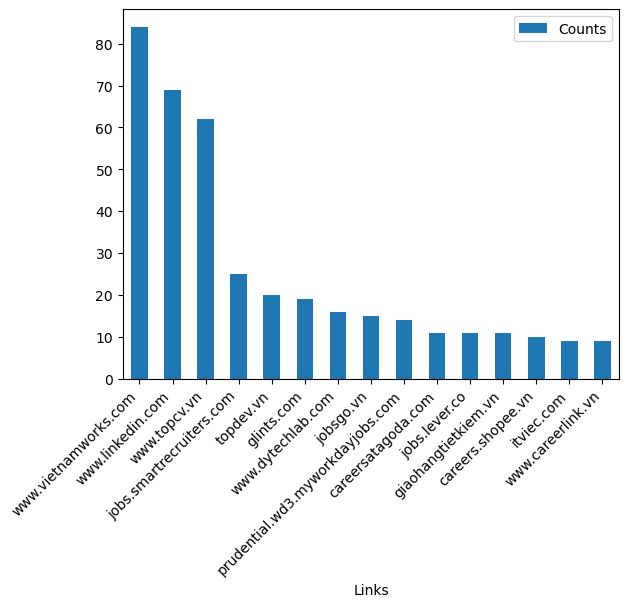

In [34]:
top = ddf.nlargest(15, 'Counts')
ax = top.plot.bar(x='Links')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

[Text(0, 0, 'careers.prep.vn'),
 Text(1, 0, 'hblab.vn'),
 Text(2, 0, 'www.rgf-hragent.asia'),
 Text(3, 0, 'www.finhay.com.vn'),
 Text(4, 0, 'lazada.com'),
 Text(5, 0, 'careers.savvycom.vn'),
 Text(6, 0, 'www.ogilvy.com'),
 Text(7, 0, 'careerstart.vn'),
 Text(8, 0, 'elfie.freshteam.com'),
 Text(9, 0, 'jobs.hrs.com'),
 Text(10, 0, 'www.pti.com.vn'),
 Text(11, 0, 'careers.tapestry.com'),
 Text(12, 0, 'jobs.gecareers.com'),
 Text(13, 0, 'sealcommerce.asia'),
 Text(14, 0, 'careers.frieslandcampina.com')]

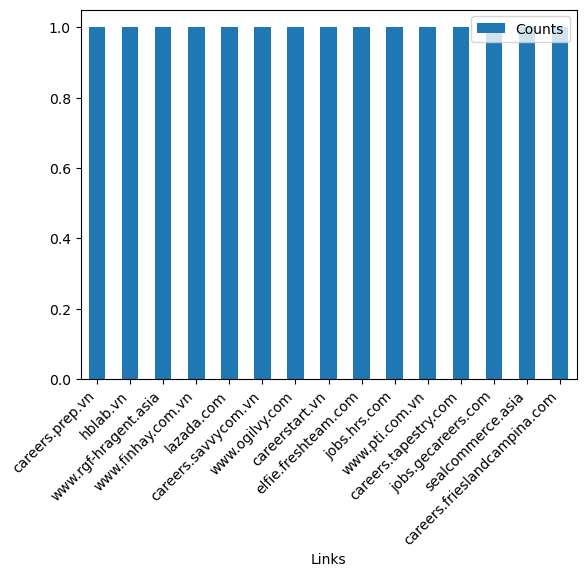

In [35]:
bot = ddf.nsmallest(15, 'Counts')
ax = bot.plot.bar(x='Links')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [45]:
df['JD Working Hour'].value_counts()

Fulltime                       717
Fulltime Hybrid                 39
Fulltime, Part-time              6
Fulltime Contract                5
Fulltime, Flexible               3
Part-time Contract               1
Fulltime, Part-time, Hybrid      1
Part-time                        1
Part-time, Flexible              1
Part-time, Freelance             1
Timely-Rate                      1
Name: JD Working Hour, dtype: int64

[Text(0, 0, 'Fulltime'),
 Text(1, 0, 'Fulltime Hybrid'),
 Text(2, 0, 'Fulltime, Part-time'),
 Text(3, 0, 'Fulltime Contract'),
 Text(4, 0, 'Fulltime, Flexible'),
 Text(5, 0, 'Part-time Contract'),
 Text(6, 0, 'Fulltime, Part-time, Hybrid'),
 Text(7, 0, 'Part-time'),
 Text(8, 0, 'Part-time, Flexible'),
 Text(9, 0, 'Part-time, Freelance'),
 Text(10, 0, 'Timely-Rate')]

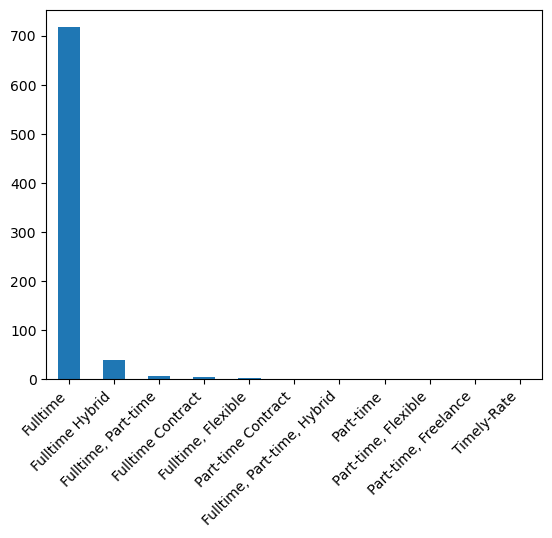

In [48]:
ax = df['JD Working Hour'].value_counts().plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [424]:
if not os.path.exists('JD'):
    os.makedirs('JD')

Dùng thư viện os để có thể tương tác với file trong máy

Tạo folder mới để lưu các JD

In [426]:
test = df.head()
test

,Job ID,JD Company,JD Title ( Eng ),JD Level,JD YOE Min,JD Location,JD Gross Salary Max*,JD Due Date,JD Working Hour,JD Note,JD Details
0,3162,Shinhan Bank Vietnam,Data Analytics Supervisor,"Senior, Lead",2.0,HCM,"1,06",1-Jul-23,Fulltime,"Experience in SQL, PowerBI is compulsory",https://www.topcv.vn/viec-lam/data-analytics-s...
1,3161,ASIM Telecom ( ASIM GROUP ),Data Engineer,Senior,4.0,"HN, HCM","2,5",Tới khi đóng link,Fulltime,Tối thiểu 4 năm kinh nghiệm trở lên về xử lý v...,https://www.linkedin.com/jobs/view/133284146
2,3159,PREP,"Leader, AI Engineer","Senior, Lead",3.0,HN,3,Tới khi đóng link,Fulltime,Minimum of 3 years of experience in a similar ...,https://careers.prep.vn/job/leader-ai-engineer/
3,3158,HBLAB,AI Engineer,"Junior, Senior",2.0,HN,"2,2",Tới khi đóng link,Fulltime,Tối thiểu 2 năm kinh nghiệm thực tế trong các ...,https://hblab.vn/recruit/ai-specialists/
4,3157,Neos,AI Engineer,"Junior, Senior",0.0,HN,3,16-Jul-23,Fulltime,"Có kiến thức, kinh nghiệm cơ bản về ChatGPT và...",https://jobsgo.vn/viec-lam/ai-engineer-1533411...


test việc lưu JD với 5 cột đầu

In [454]:
# 
# for i in range(len(test)+1):
#     # Lấy ra class trong class_df có dòng là domain
#     url = df.loc[i, 'JD Details']
#     company = df.loc[i, 'JD Company']
#     parsed_url = urllib.parse.urlparse(url)
#     domain = parsed_url.netloc
#     pattern = class_df[class_df['Links'].str.contains(domain)]['Class']
    
#     # Lấy page_source bằng selenium
#     driver = webdriver.Chrome(ChromeDriverManager().install())
#     driver.get(url)
#     page_source = driver.page_source
#     driver.quit()
    
#     # Cào Job Description trong trang thông qua page_source bằng BeautifulSoup
#     soup = BeautifulSoup(page_source, 'html.parser')
#     job_description_elem = soup.find_all("div", {"class": pattern})
    
#     if not os.path.exists(f'JD/{domain}'):
#             os.makedirs(f'JD/{domain}')
#     for jd in job_description_elem:
#         with open(f'JD/{domain}/{company}.txt', 'w', encoding='utf-8') as file:
#             file.write(jd.get_text())

In [42]:
def getCompanyDetails(i,class_df):
    url = df.loc[i, 'JD Details']
    company = df.loc[i, 'JD Company']
    level = df.loc[i, 'JD Level']
    loc = df.loc[i, 'JD Location']
    gross = df.loc[i, 'JD Gross Salary Max*']
    due = df.loc[i, 'JD Due Date']
    work = df.loc[i, 'JD Working Hour']
    note = df.loc[i, 'JD Note']
    
    details = [url, company, level, loc, gross, due, work, note]
    #           0      1       2     3     4     5    6     7
    
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc
    pattern = class_df[class_df['Links'].str.contains(domain)]['Class']
    return details,domain,pattern

def getPageSource(url):
    try:
        r = requests.get(url)
        if r.status_code == 200:
            driver = webdriver.Chrome(ChromeDriverManager().install())
            driver.get(url)
            page_source = driver.page_source
            driver.quit()
            return page_source
    except requests.exceptions.RequestException as e:
        return "Error"

def soupJDFinder(page_source, pattern):
    try:
        soup = BeautifulSoup(page_source, 'html.parser')
        job_descriptions = soup.find_all("div", {"class": pattern})
        return job_descriptions
    except Exception as e:
        return "Error"

def writeJD(domain, details, job_descriptions):
    if not os.path.exists(f'JD/{domain}'):
        os.makedirs(f'JD/{domain}')
    if job_descriptions == 'Error':
        return
    if os.path.exists(f'JD/{domain}/{details[1]}.txt'):
        return
    for jd in job_descriptions:
        with open(f'JD/{domain}/{details[1]}.txt', 'w', encoding='utf-8') as file:
            file.write(f"Bằng cấp: {details[2]}")
            file.write(f"\nĐịa điểm: {details[3]}")
            file.write(f"\nLương: {details[4]}")
            file.write(f"\nNgày hết hạn: {details[5]}")
            file.write(f"\nThời gian làm việc: {details[6]}")
            file.write(f"\nChú thích: {details[7]}")
            file.write("\n\n\nChi tiết JD:\n",)
            file.write(jd.get_text())

In [43]:
def scraper(data,class_df):
    for i in range(len(data)):
        details,domain,pattern = getCompanyDetails(i,class_df)
        print(details[0])
        page_source = getPageSource(details[0])
        job_des = soupJDFinder(page_source,pattern)
        writeJD(domain, details, job_des)

Tạo các hàm làm các nhiệm vụ khác nhau để cào dữ liệu
- getgetCompanyDetails: Nhận số i làm đầu vào, trả về dữ liệu của dòng thứ i của df, link gốc và class
- getPageSource: Nhận 1 đường link làm đầu vào, trả về page source của đường link đó
- soupJDFinder: Nhận vào page source và class, trả về JD nếu cào được, trả về "Error" nếu có lỗi
- writeJD: Nhận link gốc, dữ liệu cả 1 dòng và JD, có nhiệm vụ tạo folder con ở trong JD có tên là link gốc, và tạo ra file text có tên của công ty. Trong file text có ghi tất cả dữ liệu của cả dòng và JD.
- scraper: nhận vào 1 DataFrame và gọi các hàm trên trong vòng lặp với số vòng bằng số dòng của DataFrame

In [45]:
df = pd.read_csv('./data4.csv',index_col=0)
class_df = pd.read_csv('./class.csv',index_col=0)

In [50]:
start_time = time.time()
scraper(df,class_df)
elapsed_time = time.time() - start_time

https://www.topcv.vn/viec-lam/data-analytics-supervisor-hcm/1033042.html
https://www.linkedin.com/jobs/view/133284146
https://careers.prep.vn/job/leader-ai-engineer/
https://hblab.vn/recruit/ai-specialists/
https://jobsgo.vn/viec-lam/ai-engineer-15334112908.html
https://www.savills.com.vn/talk-to-us/careers/current-vacancies/hcmc-vacancies/(it-hk)-data-engineer.aspx
https://itviec.com/it-jobs/zalopay-senior-data-scientist-vng-corporation-3206
https://mycareer.hsbc.com/en_GB/external/PipelineDetail/Risk-Screening-Officer/178749
https://glints.com/vn/opportunities/jobs/fresh-speed-up-2023-program-for-fresher-supply-chain/f552866a-1c4b-4ad8-aaad-643e2aa1d7ac
https://glints.com/vn/opportunities/jobs/fresh-speed-up-2023-program-for-fresher-accounting-and-finance/0676cb65-d957-453a-9323-bb2d4f9f25df
https://glints.com/vn/opportunities/jobs/fresh-speed-up-2023-program-for-fresher-planning/02320e00-bf18-4ed1-bbf4-e55e9760b537
https://www.topcv.vn/viec-lam/data-validator-junior-work-in-district

https://www.vietnamworks.com/business-analytics-manager-3-1647022-jv
https://careersatagoda.com/job/5074827-manager-marketing-strategy-analytics-bangkok-based-relocation-provided
https://www.linkedin.com/jobs/view/3612351519/
https://www.linkedin.com/jobs/view/3612354386
https://www.vietnamworks.com/database-administrator-up-to-1800-1653390-jv
https://www.vietnamworks.com/growth-marketing-leader-1-1-1653431-jv
https://www.linkedin.com/jobs/view/3612354371
https://www.careerlink.vn/en/job/binh-duong-finance-analyst/2595162
https://jobsgo.vn/viec-lam/middle-senior-data-engineer-15288052940.html
https://www.linkedin.com/jobs/view/3611167701
https://careers.uobgroup.com/job/Ho-Chi-Minh-City-Campaign-Management-Senior-Analyst/938826810
https://itviec.com/it-jobs/data-engineer-back-end-python-fast-api-django-sql-burning-bros-5129
https://www.vietnamworks.com/asia-purchasing-data-analyst-1-1653202-jv
https://www.vietnamworks.com/business-intelligence-executive-6-1-1653238-jv
https://www.linke

https://billease.snaphunt.com/job/5YKJSOG2QY-VN-215
https://www.linkedin.com/jobs/view/3614490000
http://www.employmentvietnam.com/data-engineering-manager
https://anduintransact.com/careers#op-251682-software-engineer-intern
https://anduintransact.com/careers#op-551212-digitization-specialist
https://careers-vietnam.nab.com.au/jobs/senior-middle-data-engineer-ho-chi-minh-city-vietnam-hanoi-ha-noi
https://careers-vietnam.nab.com.au/jobs/data-protection-analyst-ho-chi-minh-city-vietnam
https://www.turing.com/remote-developer-jobs/j/li-promoted/data-analyst-114894-vn
https://www.turing.com/remote-developer-jobs/j/li-promoted/data-analyst-73269-vn
https://billease.snaphunt.com/job/YJ512ERSK7-VN-215
https://alohaconsulting.zohorecruit.com/jobs/Careers/613168000049977281/Ho-Chi-Minh-Hanoi-Data-Analyst
https://abbank.vn/tuyen-dung/khoi-ngan-hang-so-thuc-tap-sinh-phat-trien-san-pham-so
https://acsvietnam.com.vn/tuyen-dung
https://primedata.ai/vi/2023/05/12/senior-data-engineer/
https://katalo

https://career.vinasoy.com/viec-lam/chuyen-vien-quan-ly-ke-hoach-va-phan-tich-kinh-doanh.35a9ce9f.html
https://careers.uobgroup.com/job/Ho-Chi-Minh-City-Fraud-Detection-Analyst/936018710/
https://freec.asia/jobs/data-analyst-24-i42531
https://www.careerlink.vn/tim-viec-lam/business-intelligence-analyst/2592166
https://www.vietnamworks.com/finance-analyst-73-1-1-1-1-1642153-jv
https://topdev.vn/detail-jobs/hochiminh-development-manager-dwh-bi-ntt-data-vietnam-2030059
https://careers.mantu.com/brands/amaris-consulting/jobs/27355
https://careers.mantu.com/brands/mantu/jobs/27612
https://enouvo.com/careers/machine-learning-ai-intern-2/
https://jobsgo.vn/viec-lam/data-analysis-15233682624.html
https://topdev.vn/detail-jobs/report-developer-sql-power-bi-data-warehousing-public-bank-vietnam-pbvn-2030233
https://www.linkedin.com/jobs/view/lead-architect-for-computer-vision-at-hitachi-vantara-3603454925
https://www.linkedin.com/jobs/view/senior-analyst-key-accounts-strategy-global-chains-bangko

https://www.topcv.vn/viec-lam/data-engineer/867250.html
https://www.topcv.vn/viec-lam/data-analyst/976445.html
https://ancient8.gg/careers/Research-Analyst-Intern
https://ancient8.gg/careers/research-analyst
https://galderma.wd3.myworkdayjobs.com/en-US/External/job/Financial-Analyst_JR003659
https://www.linkedin.com/jobs/view/senior-customer-experience-analyst-at-home-credit-vietnam-3592809833
https://careers.cargill.com/job/ho-chi-minh-city/bosc-plant-finance-enterprise-senior-analyst/23251/45988832096
https://careers.cargill.com/job/ho-chi-minh-city/digital-experience-support-analyst/23251/47982412416
https://careers.cargill.com/job/ho-chi-minh-city/global-price-master-data-assistant/23251/47986956080
https://careers.cargill.com/job/ho-chi-minh-city/trade-product-control-senior-analyst/23251/48414508016
https://kompa.ai/career/data-operator/
https://profectus.talent.vn/job/nhan-vien-xu-ly-du-lieu-tieng-anh-data-processor-1786
https://profectus.talent.vn/careers/job/2364
https://jobs.

https://zalo.careers/job//senior-data-scientist-adtima-n-ycuqUZHFH3Zt4q5m
https://zalo.careers/job/data-science-manager-adtima-n-bttK4IXm90IEFCaY
https://parcelperform.freshteam.com/jobs/Dy5w3nuAYlVr/data-engineer
https://manulife.wd3.myworkdayjobs.com/en-US/MFCJH_Jobs/job/Dist7-Ho-Chi-Minh/ASSISTANT-MANAGER---MIS---DATA-ANALYTICS_JR23040093
https://thaisonfoods.vn/nhan-vien-thong-ke-phan-tich-so-lieu/
https://www.elca.vn/en/jobs/data-engineer-24hr-quick-recruitment-campaign-ho-chi-minh-city
https://hr1tech.com/viec-lam/data-operation-engineer-python-16640.html
https://hr1jobs.com/viec-lam/data-quality-data-governance-specialist-16598.html
https://alohaconsulting.zohorecruit.com/jobs/Careers/613168000041070086
https://officience.com/job/it-intern-data-science-machine-learning/
https://officience.com/job/fresher-data-engineer/
https://www.ahamove.com/job/OS
https://careers.uobgroup.com/job/Ho-Chi-Minh-City-UOBV-2023-Internship-Programme/936634610/
https://careers.vib.com.vn/careers/job/

https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://www.dytechlab.com/careers/
https://aloha1975.com/career/data-analyst/
https://aloha1975.com/career/datascientist/
https://www.jac-recruitment.vn/job/strategic-planning-manager
https://ierp.vn/thong-bao-tuyen-dung-data-warehouse-engineer/
https://www.acbjobs.com.vn/job/tmo-giam-doc-phan-tich-kinh-doanh-18199
https://www.acbjobs.com.vn/job/tmo-chuyen-vien-phan-tich-kinh-doanh-24746
https://www.acbjobs.com.vn/job/tmo-business-intelligent-analyst-manager-24863
https://www.acbjobs.com.vn/job/ho-advanced-analytics-specialist-22087
https:

In [51]:
elapsed_time

5662.509407281876

Xấp xỉ 1.57 giờ (94.2 phút - 1h34p)